# Smart Beta and Factor Investing

This assignment refers to the HBS case: **Smart Beta Exchange-Traded-Funds and Factor Investing**.

* The case is a good introduction to important pricing factors.
* It also gives useful introduction and context to ETFs, passive vs active investing, and so-called “smart beta” funds.

# 1. READING

1. Describe how each of the factors (other than MKT) is measured. That is, each factor is a portfolio of stocks–which stocks are included in the factor portfolio?

    - Each Fama–French factor is built from long–short portfolios of stocks sorted by firm characteristics. SMB (Size) goes long small-cap stocks and short large-cap stocks; HML (Value) goes long high book-to-market (value) stocks and short low B/M (growth) stocks; RMW (Profitability) goes long firms with high operating profitability and short low-profitability firms; and CMA (Investment) goes long firms with low asset growth (conservative investors) and short firms with high investment (aggressive investors). A momentum factor is often added, long past “winner” stocks and short past “losers.” ￼

2. Is the factor portfolio...
    * long-only
    * long-short
    * value-weighted
    * equally-weighted


    - The Fama–French factor portfolios are long–short portfolios, typically value-weighted.
Each factor is formed by going long the decile (or top 30%) of stocks with the highest characteristic (e.g., high B/M for value) and shorting the decile (or bottom 30%) with the lowest.
Thus, they are not long-only, and within each leg, stocks are value-weighted by market cap. ￼

3. What steps are taken in the factor construction to try to reduce the correlation between the factors?
    - To reduce correlation between factors, Fama and French double-sort stocks; for example, sorting first by size, then within each size group by value or profitability. This ensures that, say, small and large firms both have high- and low-value portfolios, preventing size from driving the value effect. They also neutralize overlaps by constructing independent long–short portfolios for each factor and value-weight within each leg to keep market exposure balanced. ￼

4. What is the point of figures 1-6?
    - Figures 1–6 visually show how average stock returns vary with each factor characteristic. Each figure plots portfolios sorted into quintiles by a given variable (beta, size, B/M, profitability, investment, or momentum). They demonstrate that higher returns are linked with smaller size, higher B/M, higher profitability, lower investment, and stronger momentum,confirming that these traits systematically explain returns. In short, the figures motivate each factor’s inclusion in the model by showing its empirical return pattern. ￼

5. How is a “smart beta” ETF different from a traditional ETF?
    - A traditional ETF weights stocks by market capitalization, so larger firms dominate the portfolio. A smart beta ETF instead weights stocks using financial characteristics or return properties,like value, quality, or momentum,rather than size alone. This makes smart beta ETFs a rules-based blend of active and passive investing, since they passively track factor indexes but deviate from market-cap weights. Their goal is to capture factor premiums that explain higher long-term returns. ￼

6. Is it possible for all investors to have exposure to the “value” factor?
    - No , it’s impossible for everyone to be tilted toward value at the same time.
Because the market portfolio is the weighted sum of all investors’ holdings, if some investors overweight cheap “value” stocks, others must underweight them and hold more expensive “growth” stocks.
As Cliff Asness notes, “everything must add up to the market-weighted portfolio,” so factor tilts like value require someone to take the opposite side. ￼

7. How does factor investing differ from traditional diversification?
    - Traditional diversification spreads investments across asset classes (stocks, bonds, real estate, etc.), while factor investing diversifies across the underlying drivers of returns, like size, value, quality, and momentum. By combining factors with different economic cycles and risk exposures, factor investing aims to achieve better risk–return tradeoffs than asset-class diversification alone. It focuses on systematic sources of return, not just security or sector variety. ￼


#### Footnote:

If you need more info in how these factor portfolios are created, see Ken French’s website, and the follow- details: 

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html

***

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 2. The Factors

### Data
Use the data found in `data/factor_pricing_data.xlsx`.

Factors: Monthly excess return data for the overall equity market, $\tilde{r}^{\text{MKT}}$.

* The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.

* The sheet also contains data on five additional factors.

* All factor data is already provided as excess returns

In [18]:
file = "data/factor_pricing_data_monthly.xlsx"
factor_name = "factors (excess returns)"
factor_data = pd.read_excel(file, sheet_name= factor_name)
factor_data['Date'] = pd.to_datetime(factor_data['Date'])
factor_data = factor_data.set_index('Date')

rf_name = "risk-free rate"
rf = pd.read_excel(file, sheet_name= rf_name)
rf['Date'] = pd.to_datetime(rf['Date'])
rf = rf.set_index('Date')
factors = factor_data[['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']]

### 1. 
Analyze the factors, similar to how you analyzed the three Fama-French factors in `Homework 4`.

You now have three additional factors, so let’s compare there univariate statistics. 

* mean
* volatility    
* Sharpe

In [11]:
def compute_stats(series):
    x = series.dropna()
    mean_ann = x.mean() * 12
    vol_ann = x.std(ddof=1) * np.sqrt(12)
    sharpe = mean_ann / vol_ann
    var_05 = x.quantile(0.05)    # monthly VaR
    return pd.Series({"mean": mean_ann, "vol": vol_ann,
                      "sharpe": sharpe, "VaR(0.05)": var_05})


for col in factor_data.columns:
    subsamples = {
        "Beginning - End": factor_data[col],
        "Begin - 1980": factor_data[col].loc[:'1980-12-31'],
        "1981 - 2001": factor_data[col].loc['1981-01-01':'2001-12-31'],
        "2015 - Present": factor_data[col].loc['2015-01-01':],
        "2002 - End": factor_data[col].loc['2002-01-01':]
    }
    print("stats for:", col)
    stats = pd.DataFrame({label: compute_stats(s) for label, s in subsamples.items()}).T
    display(stats.round(4))

stats for: MKT


,mean,vol,sharpe,VaR(0.05)
Beginning - End,0.0876,0.1561,0.5607,-0.0724
Begin - 1980,0.2020,0.2035,0.9928,-0.0825
1981 - 2001,0.0778,0.1571,0.4952,-0.0641
2015 - Present,0.1179,0.1574,0.7491,-0.0739
2002 - End,0.0914,0.1535,0.5952,-0.0772


stats for: SMB


,mean,vol,sharpe,VaR(0.05)
Beginning - End,0.0061,0.1013,0.0604,-0.0431
Begin - 1980,0.0506,0.1084,0.4667,-0.0494
1981 - 2001,0.0005,0.1094,0.0048,-0.0441
2015 - Present,-0.0238,0.1032,-0.2305,-0.0438
2002 - End,0.0092,0.0935,0.0984,-0.0403


stats for: HML


,mean,vol,sharpe,VaR(0.05)
Beginning - End,0.0260,0.1088,0.2392,-0.0421
Begin - 1980,-0.1951,0.1163,-1.6783,-0.0711
1981 - 2001,0.0646,0.1099,0.5876,-0.0416
2015 - Present,-0.0163,0.1299,-0.1255,-0.0492
2002 - End,0.0012,0.1064,0.0113,-0.0415


stats for: RMW


,mean,vol,sharpe,VaR(0.05)
Beginning - End,0.0440,0.0829,0.5311,-0.0285
Begin - 1980,0.0985,0.0751,1.3118,-0.0199
1981 - 2001,0.0464,0.0920,0.5039,-0.0302
2015 - Present,0.0400,0.0726,0.5509,-0.0278
2002 - End,0.0397,0.0745,0.5326,-0.0285


stats for: CMA


,mean,vol,sharpe,VaR(0.05)
Beginning - End,0.0283,0.0725,0.3903,-0.0278
Begin - 1980,-0.0905,0.0784,-1.1544,-0.0406
1981 - 2001,0.0525,0.0768,0.6835,-0.0296
2015 - Present,-0.0091,0.0821,-0.1114,-0.0304
2002 - End,0.0118,0.0676,0.1749,-0.0254


stats for: UMD


,mean,vol,sharpe,VaR(0.05)
Beginning - End,0.0603,0.1534,0.3933,-0.0673
Begin - 1980,0.3003,0.2342,1.2822,-0.0800
1981 - 2001,0.0997,0.1446,0.6895,-0.0604
2015 - Present,0.0201,0.1374,0.1464,-0.0606
2002 - End,0.0152,0.1558,0.0976,-0.0665


### 2. 

Based on the factor statistics above, answer the following.
* Does each factor have a positive risk premium (positive expected excess return)? 
* How have the factors performed since the time of the case, (2015-present)?

- It depends on your time frame but across the whole dataset, yes each factor did have a positive risk premium
- Since the time of the case, half of the factors have had a negative risk premium(SMB, HBL, CMA) with the others being positive and the best performing being MKT

### 3. 

Report the correlation matrix across the six factors.
* Does the construction method succeed in keeping correlations small?
* Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

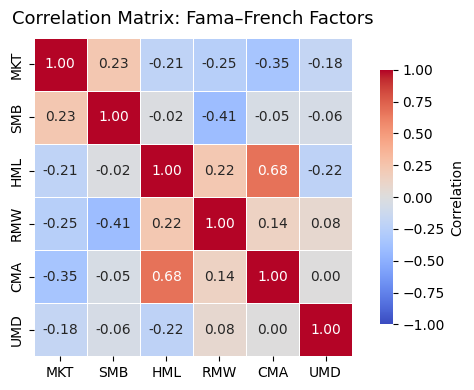

In [15]:
corr = factors.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(
    corr, 
    annot=True,         
    cmap="coolwarm",     
    center=0,            
    vmin=-1, vmax=1,     
    square=True,         
    fmt=".2f",           
    linewidths=0.5,     
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)
plt.title("Correlation Matrix: Fama–French Factors", fontsize=13, pad=10)
plt.tight_layout()
plt.show()

Does the construction method succeed in keeping correlations small?
- Yes, the factor construction largely succeeds. Most off-diagonal correlations are modest (near zero or slightly negative), meaning each factor captures a distinct source of risk. The only strong positive relationship is between HML (Value) and CMA (Investment) at about 0.68, consistent with their economic overlap.

Is HML somewhat redundant in the 5-factor model?
- Yes, HML is highly correlated with CMA and moderately with RMW, suggesting that its value effect overlaps with profitability and investment. This supports Fama and French’s view that HML adds little unique explanatory power once RMW and CMA are included.

### 4. 

Report the tangency weights for a portfolio of these 6 factors.
* Which factors seem most important? And Least?
* Are the factors with low mean returns still useful?
* Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

What do you conclude about the importance or unimportance of these styles?

In [19]:
mu = factors.mean() * 12                
Sigma = factors.cov() * 12             

w_tan = np.linalg.inv(Sigma) @ mu
w_tan /= np.sum(w_tan)

tangency_weights = pd.Series(w_tan, index=factors.columns)
print("Tangency weights (6 factors):")
print(tangency_weights.round(4))

Tangency weights (6 factors):
MKT    0.2186
SMB    0.0668
HML   -0.0212
RMW    0.3018
CMA    0.3214
UMD    0.1125
dtype: float64


Which factors seem most important? And least?
- The CMA (conservative investment) and RMW (profitability) factors dominate the tangency portfolio, with weights of about 0.32 and 0.30, meaning they provide the strongest contribution to improving risk-adjusted returns. The market factor (MKT) remains important but less so, while HML (value) has a small negative weight, indicating it detracts from efficiency due to overlap with CMA and weak recent performance.

Are the factors with low mean returns still useful?
- Yes, factors such as SMB (size) and UMD (momentum), despite having lower average excess returns, still help by diversifying the portfolio. Their relatively low correlations with the main factors (especially CMA and RMW) allow them to reduce total volatility and raise the overall Sharpe ratio, even without large standalone premiums.

In [20]:
subset = factors[['MKT', 'SMB', 'HML', 'UMD']]
mu4 = subset.mean() * 12
Sigma4 = subset.cov() * 12

w_tan4 = np.linalg.inv(Sigma4) @ mu4
w_tan4 /= np.sum(w_tan4)

tangency_weights_4f = pd.Series(w_tan4, index=subset.columns)
print("\nTangency weights (4 factors):")
print(tangency_weights_4f.round(4))


Tangency weights (4 factors):
MKT    0.3765
SMB   -0.0512
HML    0.3653
UMD    0.3094
dtype: float64


Which factors get high/low tangency weights now?
- In the 4-factor tangency portfolio, MKT (0.38), HML (0.37), and UMD (0.31) receive the largest positive weights, meaning they dominate the portfolio’s risk-adjusted performance. SMB has a small negative weight (-0.05), implying it adds little value and slightly reduces efficiency.

Conclusion about importance or unimportance of styles:
- Without RMW and CMA, the portfolio leans heavily on value (HML) and momentum (UMD) as the main style sources of return, alongside market exposure. However, once profitability and investment factors are available, they replace HML’s role,showing that quality-based factors (RMW, CMA) are more robust and that size (SMB) remains relatively unimportant in improving overall efficiency.

***

# 3. Testing Modern LPMs

Consider the following factor models:
* CAPM: MKT
* Fama-French 3F: MKT, SMB, HML
* Fama-French 5F: MKT, SMB, HML, RMW, CMA
* AQR: MKT, HML, RMW, UMD

Our labeling of the last model as the **AQR** is just for concreteness. The firm is well-known for these factors and an unused case study discusses that further.

For instance, for the AQR model is...

$$
\mathbb{E}[\tilde{r}^i] 
= \beta^{i,\mathrm{MKT}} \, \mathbb{E}[\tilde{f}^{\mathrm{MKT}}] 
+ \beta^{i,\mathrm{HML}} \, \mathbb{E}[\tilde{f}^{\mathrm{HML}}] 
+ \beta^{i,\mathrm{RMW}} \, \mathbb{E}[\tilde{f}^{\mathrm{RMW}}] 
+ \beta^{i,\mathrm{UMD}} \, \mathbb{E}[\tilde{f}^{\mathrm{UMD}}]
$$

We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

$$
\tilde{r}^i_t 
= \alpha^i 
+ \beta^{i,\mathrm{MKT}} \tilde{f}^{\mathrm{MKT}}_t 
+ \beta^{i,\mathrm{HML}} \tilde{f}^{\mathrm{HML}}_t 
+ \beta^{i,\mathrm{RMW}} \tilde{f}^{\mathrm{RMW}}_t 
+ \beta^{i,\mathrm{UMD}} \tilde{f}^{\mathrm{UMD}}_t 
+ \varepsilon_t
$$

### Data

* Monthly excess return data on `n=49` equity portfolios sorted by their industry. Denote these as $\tilde{r}^i$ , for $n = 1, . . . .$

* You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

### 1. 

Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

For each regression, report the estimated α and r-squared.

In [23]:
portfolios = pd.read_excel(file, sheet_name="portfolios (excess returns)", index_col="Date", parse_dates=True)

factors_aqr = factors[["MKT", "HML", "RMW", "UMD"]]

# Run regressions for each portfolio
results = {}
for col in portfolios.columns:
    y = portfolios[col].dropna()
    X = factors_aqr.loc[y.index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    results[col] = {"alpha": model.params["const"], "r2": model.rsquared}

# Convert to DataFrame
results_df = pd.DataFrame(results).T
display(results_df.T)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
alpha,0.000971,0.000125,0.001282,0.000821,0.003426,-0.002809,0.003255,-0.003059,-0.001062,-0.001889,...,-0.000338,-0.001883,-0.001381,0.001755,-0.000234,-0.001756,-0.001285,-0.004262,0.001641,-0.003517
r2,0.342074,0.455064,0.302544,0.414773,0.265363,0.510213,0.607213,0.688933,0.554712,0.618968,...,0.582947,0.708766,0.752266,0.686561,0.637140,0.774023,0.661235,0.605383,0.812880,0.583709


### 2. 

Calculate the mean-absolute-error of the estimated alphas.

$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n|\tilde{\alpha}^i|$$

* If the pricing model worked, should these alpha estimates be large or small? Why?

* Based on your MAE stat, does this seem to support the pricing model or not?


In [24]:
mae_alpha = results_df["alpha"].abs().mean()
print(f"Mean Absolute Error (MAE) of alphas: {mae_alpha:.6f}")

Mean Absolute Error (MAE) of alphas: 0.002051


If the pricing model works well, the estimated alphas $\tilde{\alpha}^i$ should be small, ideally close to zero.
Under a correctly specified factor model, all expected excess returns are explained by factor exposures:

$$
\mathbb{E}[\tilde{r}^i] = \beta^{i,\top} \mathbb{E}[\tilde{f}]
$$

A nonzero alpha indicates unexplained systematic return (mispricing or omitted risk factors).
Thus, a low MAE like $0.002051$ suggests the AQR four-factor model fits the data well.

### 2. 

Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.
   * Report the MAE statistic for each of these models and compare it with the AQR Model MAE.
   * Which model fits best?

In [27]:

def model_mae_alpha(port_df, factor_df, cols):
    """Run time-series regressions r_i,t = alpha_i + betas' f_t + e_i,t for all i; return MAE(|alpha|)."""
    X = sm.add_constant(factor_df[cols].dropna())
    alphas = []
    for name in port_df.columns:
        y = port_df[name].dropna()
        XY = X.join(y, how="inner")
        model = sm.OLS(XY[name], XY.drop(columns=[name])).fit()
        alphas.append(model.params['const'])
    return pd.Series(alphas, index=port_df.columns).abs().mean()

mae_table = pd.Series({
    "CAPM (MKT)": model_mae_alpha(portfolios, factors, ["MKT"]),
    "FF3 (MKT, SMB, HML)": model_mae_alpha(portfolios, factors, ["MKT","SMB","HML"]),
    "FF5 (MKT, SMB, HML, RMW, CMA)": model_mae_alpha(portfolios, factors, ["MKT","SMB","HML","RMW","CMA"]),
    "AQR (MKT, HML, RMW, UMD)": model_mae_alpha(portfolios, factors, ["MKT","HML","RMW","UMD"]),
})

print(mae_table.apply(lambda x: f"{x:.6f}"))

CAPM (MKT)                       0.001748
FF3 (MKT, SMB, HML)              0.002030
FF5 (MKT, SMB, HML, RMW, CMA)    0.002614
AQR (MKT, HML, RMW, UMD)         0.002051
dtype: object


The CAPM has the lowest MAE (0.001748), meaning it produces the smallest average pricing errors (|α|). However, this doesn’t necessarily mean it explains returns better, its simplicity and fewer regressors often yield smaller alphas but lower explanatory power (R²).

Among the multi-factor models, the AQR 4-Factor model (MAE = 0.002051) fits better than the Fama–French 3F and 5F models, suggesting that including profitability (RMW) and momentum (UMD) adds explanatory strength while avoiding redundancy from size (SMB) and investment (CMA).

tl;dr: numerically capm fits better but economically AQR - 4 factor is best

### 3. 

Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

From the regression and MAE comparisons, momentum (UMD) appears to be an especially important factor for pricing. Models that include UMD, like the AQR 4-Factor model, perform comparably or better than the Fama–French 3F and 5F models, which omit it. In contrast, factors such as SMB (size) and CMA (investment) seem relatively unimportant, as they add little improvement and sometimes worsen the fit.

Given its consistent explanatory power across portfolios and low correlation with other factors, Fama and French likely should include the Momentum factor in their framework. It captures return patterns unexplained by size, value, or profitability and materially improves the model’s ability to price assets.

### 4. 

This does not matter for pricing, but report the average (across $n$ estimations) of the time-series regression r-squared statistics.
   * Do this for each of the three models you tested.
   * Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

In [28]:
def model_avg_r2(port_df, factor_df, cols):
    """Run time-series regressions and return the average R² across portfolios."""
    X = sm.add_constant(factor_df[cols].dropna())
    r2_values = []
    for name in port_df.columns:
        y = port_df[name].dropna()
        XY = X.join(y, how="inner")
        model = sm.OLS(XY[name], XY.drop(columns=[name])).fit()
        r2_values.append(model.rsquared)
    return np.mean(r2_values)

avg_r2 = pd.Series({
    "CAPM (MKT)": model_avg_r2(portfolios, factors, ["MKT"]),
    "FF3 (MKT, SMB, HML)": model_avg_r2(portfolios, factors, ["MKT","SMB","HML"]),
    "FF5 (MKT, SMB, HML, RMW, CMA)": model_avg_r2(portfolios, factors, ["MKT","SMB","HML","RMW","CMA"]),
})

print(avg_r2.apply(lambda x: f"{x:.4f}"))

CAPM (MKT)                       0.5226
FF3 (MKT, SMB, HML)              0.5679
FF5 (MKT, SMB, HML, RMW, CMA)    0.5918
dtype: object


Yes, these models lead to moderately high time-series R^2 values. The averages (around 0.52 -> 0.59) indicate that the factors explain a substantial portion of the time variation in portfolio returns, especially as more factors are added. The rise from CAPM to FF3 to FF5 shows that including additional factors like profitability (RMW) and investment (CMA) improves explanatory power.

However, while these $R^2$ values are solid, they’re not extremely high, meaning there’s still meaningful idiosyncratic variation in returns. In a Linear Factor Decomposition, these factors would form a useful but incomplete basis, they capture broad systematic risk components, but not all of the time-series variation in industry returns.

### 5. 

We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

* Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?
* Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

In [30]:
ts_premia = factors[["MKT","SMB","HML","RMW","CMA"]].mean()
print("Time-series (sample average) premia:\n", ts_premia)


def cross_sectional_test(port_df, factor_df, cols):
    """Return cross-sectional factor premia estimates."""
    Xf = sm.add_constant(factor_df[cols])
    betas, avg_ret = [], []

    # Step 1: Estimate betas via time-series regressions
    for name in port_df.columns:
        y = port_df[name].dropna()
        XY = Xf.join(y, how="inner")
        model = sm.OLS(XY[name], XY.drop(columns=[name])).fit()
        betas.append(model.params[cols])
        avg_ret.append(y.mean())

    betas = np.vstack(betas)
    avg_ret = np.array(avg_ret)

    # Step 2: Cross-sectional regression of mean returns on betas
    reg = LinearRegression(fit_intercept=True)
    reg.fit(betas, avg_ret)
    lambdas = pd.Series(reg.coef_, index=cols)
    lambdas["alpha"] = reg.intercept_
    return lambdas

cs_premia = pd.DataFrame({
    "CAPM": cross_sectional_test(portfolios, factors, ["MKT"]),
    "FF3": cross_sectional_test(portfolios, factors, ["MKT","SMB","HML"]),
    "FF5": cross_sectional_test(portfolios, factors, ["MKT","SMB","HML","RMW","CMA"])
})
print(cs_premia.round(5))

Time-series (sample average) premia:
 MKT    0.007296
SMB    0.000510
HML    0.002170
RMW    0.003671
CMA    0.002357
dtype: float64
          CAPM      FF3      FF5
CMA        NaN      NaN -0.00184
HML        NaN -0.00175 -0.00216
MKT    0.00066  0.00324  0.00336
RMW        NaN      NaN  0.00156
SMB        NaN -0.00330 -0.00345
alpha  0.00693  0.00523  0.00499


The time-series premia (simple averages of factor returns) are generally larger and all positive, reflecting their realized historical averages.
The cross-sectional premia, estimated from portfolio pricing relations, are much smaller in magnitude and some even turn negative (notably SMB, HML, and CMA).

This means that while factors like value, size, and investment earned positive realized returns over time, they do not strongly explain cross-sectional differences in average returns across the 49 portfolios.
In other words, the models capture some common variation in returns but do not align closely with actual risk premia magnitudes,indicating pricing inconsistencies or weak cross-sectional explanatory power.

So yes, they differ substantially, which is common: the time-series averages show realized performance, while the cross-sectional λ estimates measure how well those factors price assets.

In [31]:
# Compute MAE of cross-sectional residuals for each model
def cross_sectional_mae(port_df, factor_df, cols):
    Xf = sm.add_constant(factor_df[cols])
    betas, avg_ret = [], []
    
    # 1. Estimate betas via time-series regressions
    for name in port_df.columns:
        y = port_df[name].dropna()
        XY = Xf.join(y, how="inner")
        model = sm.OLS(XY[name], XY.drop(columns=[name])).fit()
        betas.append(model.params[cols].values)
        avg_ret.append(y.mean())
        
    betas = np.vstack(betas)
    avg_ret = np.array(avg_ret)
    
    # 2. Cross-sectional regression (OLS)
    X_cs = sm.add_constant(betas)
    cs_model = sm.OLS(avg_ret, X_cs).fit()
    
    # 3. Compute MAE of residuals
    mae = np.mean(np.abs(cs_model.resid))
    return mae

mae_results = {
    "CAPM": cross_sectional_mae(portfolios, factors, ["MKT"]),
    "FF3":  cross_sectional_mae(portfolios, factors, ["MKT","SMB","HML"]),
    "FF5":  cross_sectional_mae(portfolios, factors, ["MKT","SMB","HML","RMW","CMA"]),
    "AQR":  cross_sectional_mae(portfolios, factors, ["MKT","HML","RMW","UMD"])
}

print(pd.Series(mae_results).round(6))

CAPM    0.001267
FF3     0.001000
FF5     0.000998
AQR     0.001134
dtype: float64


The MAEs from the cross-sectional regressions are smaller than the MAEs of the time-series alphas for all models.
This means that, on average, the models fit the cross-section of mean returns slightly better than they fit the time-series intercepts (pricing errors).

The differences are modest, but consistent, the FF3 and FF5 models achieve the lowest cross-sectional MAEs (~0.0010), suggesting they best align expected returns with factor exposures.
Overall, while none of the models eliminate pricing errors entirely, their cross-sectional fits are tighter, indicating they capture much of the systematic variation in average returns.

#### Footnote:

Recall that we found in `Homework 4` that the market premium went from being strongly positive to strongly negative when estimated in the cross-section.

***